# Problem Statement
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

 -- Which variables are significant in predicting the demand for shared bikes.
 -- How well those variables describe the bike demands

Goal:
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

In [1]:
#Load the necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings

# Set required options 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
sns.set_style("whitegrid")

## Metadata - Data Dictionary

Dataset characteristics
=========================================
day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	
================================================

In [2]:
## Load Bike data
bike_data = pd.read_csv("day.csv")
bike_data.shape

(730, 16)

In [3]:
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## EDA- Step 1: Understanding the data


In [4]:
# Checking data types
bike_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
bike_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [6]:
# Checking all the columns with null values
null_count = bike_data.isnull().sum()
null_count[null_count > 0].sort_values(ascending=False)

Series([], dtype: int64)

### EDA- Step 2 - Data Cleanup
- Since there is no any null value so cleaning null values are not required here.

In [7]:
# CHecking if there is any column where all the values are same.
columns_with_unique_value_counts = bike_data.nunique().sort_values(ascending=True)
columns_with_unique_value_counts

yr              2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
mnth           12
temp          498
hum           594
casual        605
windspeed     649
registered    678
atemp         689
cnt           695
instant       730
dteday        730
dtype: int64

-- There is no any such column where all the values are same.

In [8]:
# Renaming some of the columns to make it more readable
bike_data = bike_data.rename(columns={'yr': 'year', 'mnth': 'month', 'hum':'humidity'})

## EDA- Step 3- Standardising Values
Some fields would be having invalid values, which would make it difficult to analyze. 
Also, some categorical columns might have unreadable values we will make it more readable

In [9]:
#season : season (1:spring, 2:summer, 3:fall, 4:winter)

season_map = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
bike_data['season'] = bike_data['season'].map(season_map)

In [10]:
# Currently we have data for 2 year only, it might be for many more year so taking a generic way here
#yr : year (0: 2018, 1:2019)
yr_map = {0:2018, 1:2019}
bike_data['year'] = bike_data['year'].map(yr_map)

In [11]:
# Mapping month column as more readable form
bike_data.month = bike_data.month.map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})

In [12]:
# Mapping the weekday column column as more readable form
bike_data.weekday = bike_data.weekday.map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat'})

In [13]:
# Mapping the weathersit column column as more readable form
bike_data.weathersit = bike_data.weathersit.map({1:'Clear',2:'Misty',3:'Light_snowrain',4:'Heavy_snowrain'})

In [14]:
bike_data.head(100)

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,2018,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,2018,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,2018,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,2018,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,2018,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,06-04-2018,summer,2018,apr,0,wed,1,Clear,16.024153,19.38040,47.0833,17.625221,413,2395,2808
96,97,07-04-2018,summer,2018,apr,0,thu,1,Clear,17.937500,21.68480,60.2917,10.874904,571,2570,3141
97,98,08-04-2018,summer,2018,apr,0,fri,1,Misty,13.769153,16.22395,83.6250,15.208464,172,1299,1471
98,99,09-04-2018,summer,2018,apr,0,sat,0,Misty,14.042500,17.07645,87.7500,8.916561,879,1576,2455


In [15]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   year        730 non-null    int64  
 4   month       730 non-null    object 
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    object 
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    object 
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  humidity    730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(7), object(5)
memory usage: 91.4+ KB


## Finding :
The bike dataset has 730 rows and 16 columns
Except one date column, all other are either float or integer type.
Some fields are categorical in nature, but they are either integer/float type.

## Removing redundant and unwanted columns
instant : Its only an index value<br>
dteday : This has the date, Since we already have seperate columns for 'year' & 'month', so we can remove that
casual and registered seems to be the breakup by category for cnt column.

In [16]:
bike_data_new = bike_data
bike_data_new = bike_data_new.drop(['instant', 'dteday','casual','registered'], axis=1)
bike_data_new

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,2018,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,2019,dec,0,thu,1,Misty,10.420847,11.33210,65.2917,23.458911,2114
726,spring,2019,dec,0,fri,1,Misty,10.386653,12.75230,59.0000,10.416557,3095
727,spring,2019,dec,0,sat,0,Misty,10.386653,12.12000,75.2917,8.333661,1341
728,spring,2019,dec,0,sun,0,Clear,10.489153,11.58500,48.3333,23.500518,1796


In [17]:
# COnvert these variables as category 
  #'mnth', 'weekday', 'season' & 'weathersit'.
bike_data_new['season']=bike_data_new['season'].astype('category')
bike_data_new['weathersit']=bike_data_new['weathersit'].astype('category')
bike_data_new['month']=bike_data_new['month'].astype('category')
bike_data_new['weekday']=bike_data_new['weekday'].astype('category')
bike_data_new['holiday']=bike_data_new['holiday'].astype('category')
bike_data_new['workingday']=bike_data_new['workingday'].astype('category')
bike_data_new['year']=bike_data_new['year'].astype('category')

In [18]:
bike_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   year        730 non-null    category
 2   month       730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   humidity    730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(7), float64(4), int64(1)
memory usage: 35.1 KB


# Step2: Visualizations

### Plotting the categorical columns to see how predictor variable stands against the target variable

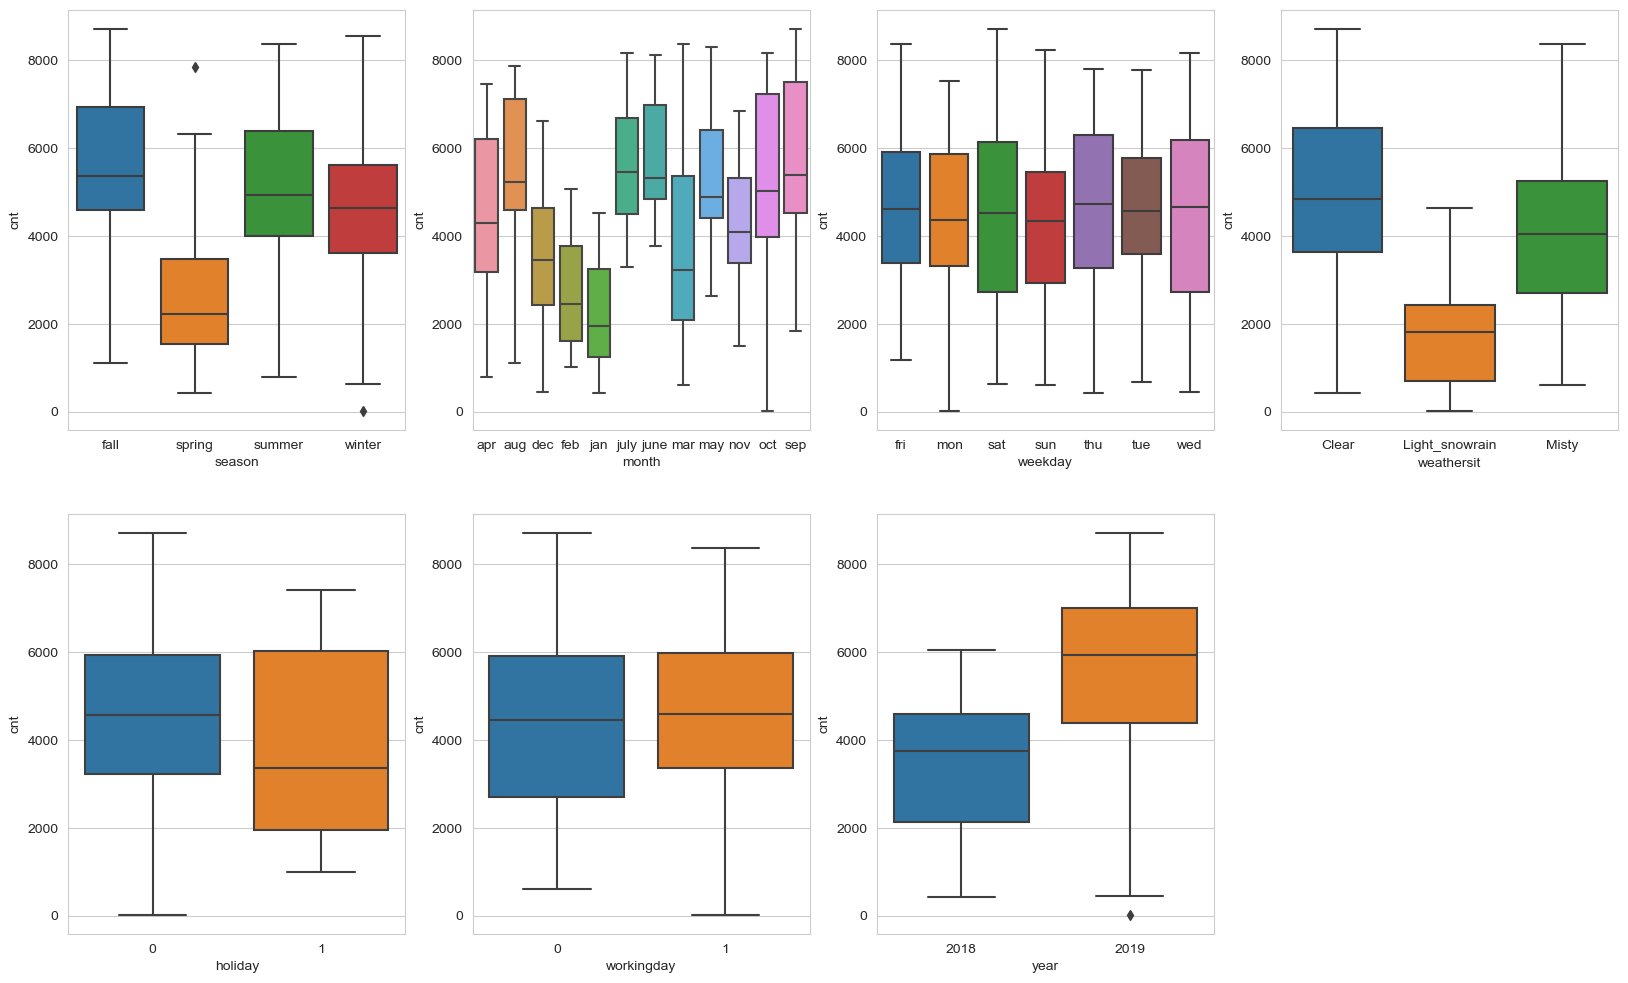

In [19]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_data_new)
plt.subplot(2,4,2)
sns.boxplot(x = 'month', y = 'cnt', data = bike_data_new)
plt.subplot(2,4,3)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_data_new)
plt.subplot(2,4,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_data_new)
plt.subplot(2,4,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_data_new)
plt.subplot(2,4,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_data_new)
plt.subplot(2,4,7)
sns.boxplot(x = 'year', y = 'cnt', data = bike_data_new)
plt.show()

In [20]:
# function to create barplot related to categorical columns

def plot_categorical_column(column):
    plt.figure(figsize = (12,6))
    plt.subplot(1,2,1)
    sns.barplot(x=column,y='cnt', data=bike_data_new)
    plt.subplot(1,2,2)
    sns.barplot(x=column,y='cnt',data=bike_data_new, hue='year',palette='Set1') # Plotting per year
    plt.show()

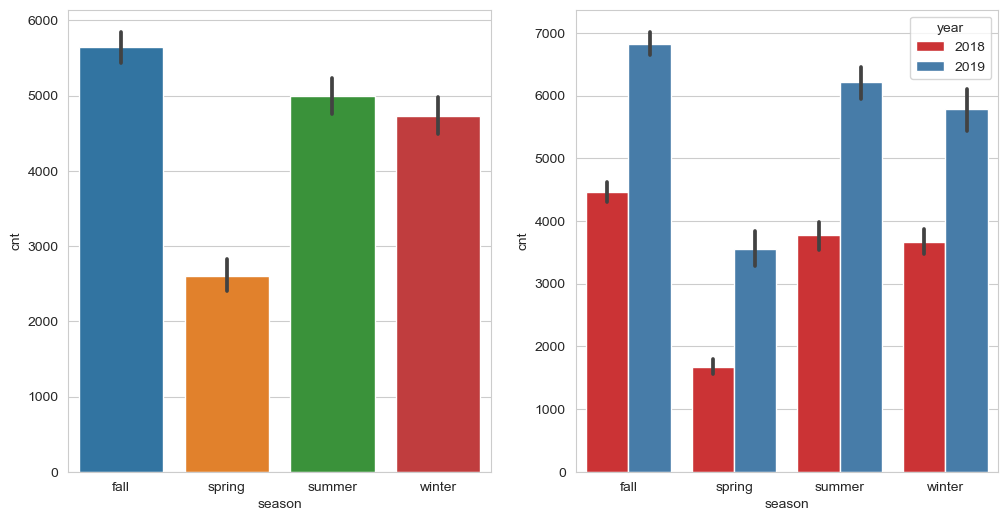

In [21]:
# plotting bar plot for season column
plot_categorical_column('season')

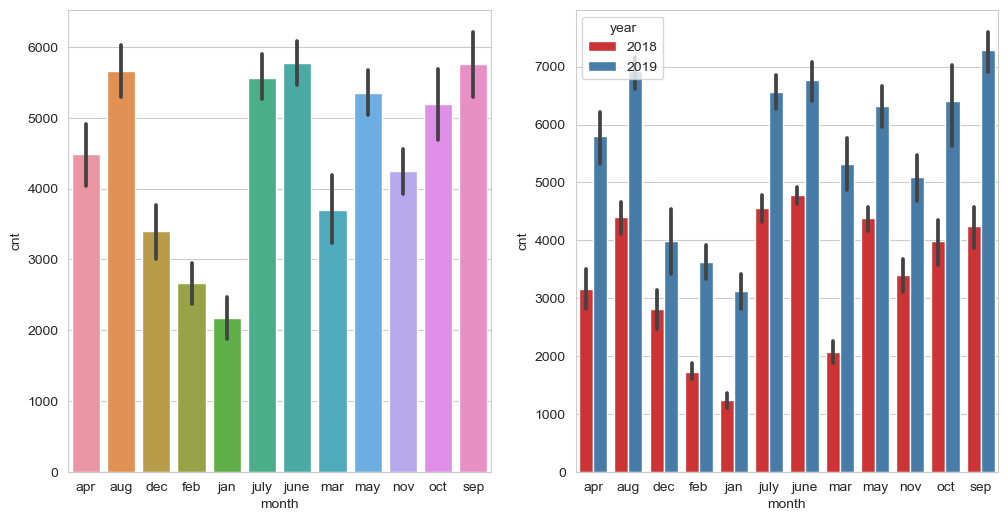

In [22]:
# plotting bar plot for season column
plot_categorical_column('month')

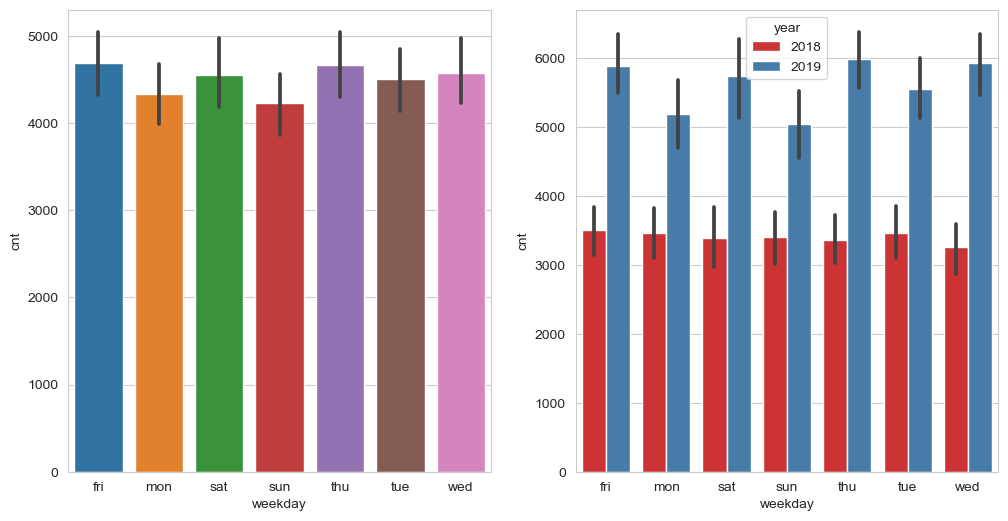

In [23]:
# plotting bar plot for weekday column
plot_categorical_column('weekday')

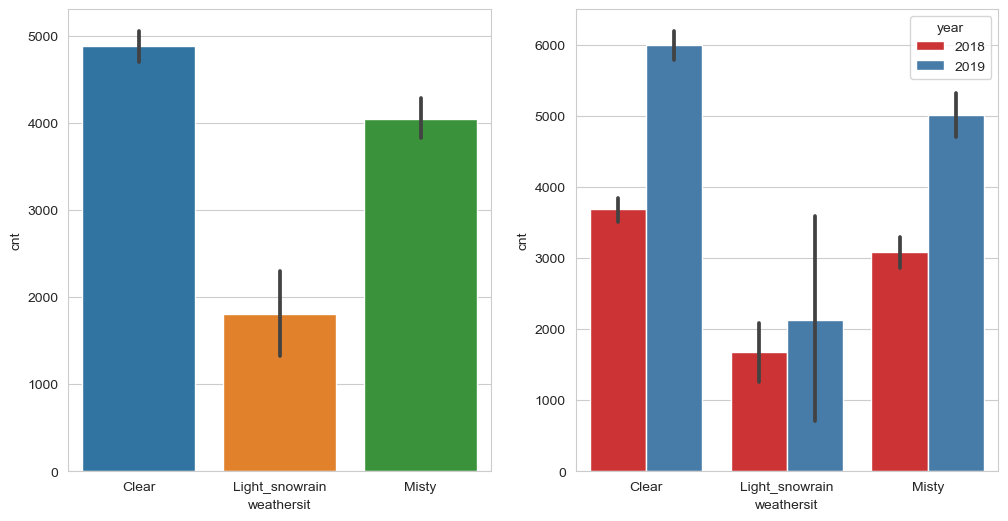

In [24]:
# plotting bar plot for weathersit column
plot_categorical_column('weathersit')

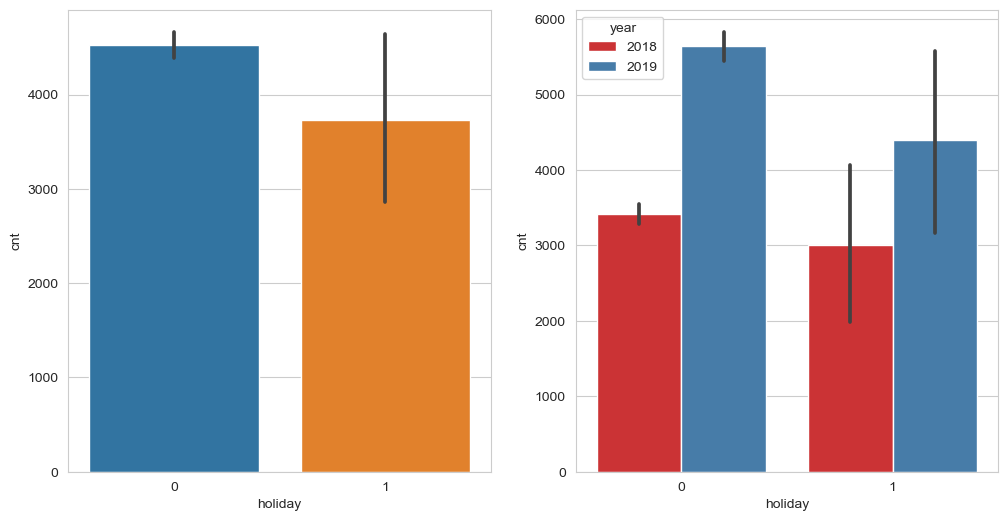

In [25]:
# plotting bar plot for holiday column
plot_categorical_column('holiday')

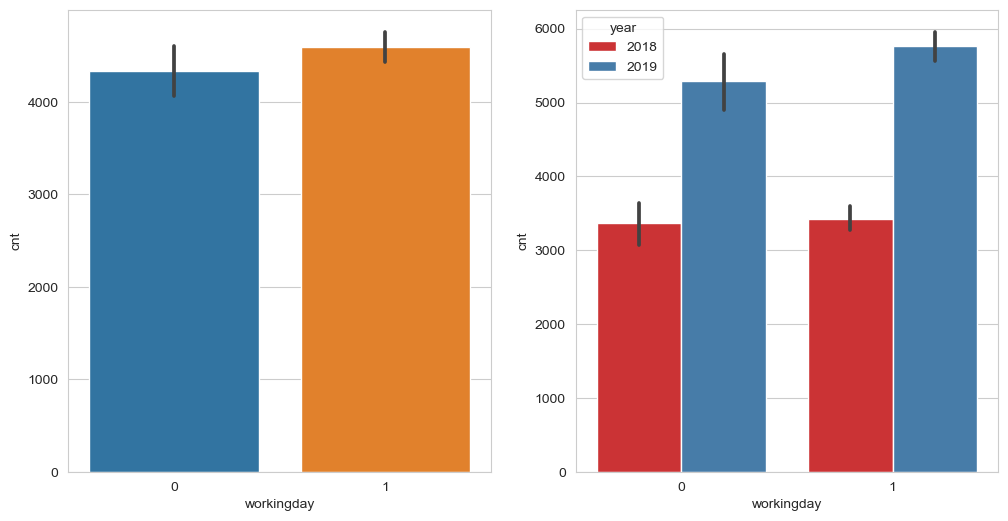

In [26]:
# plotting bar plot for workingday column
plot_categorical_column('workingday')

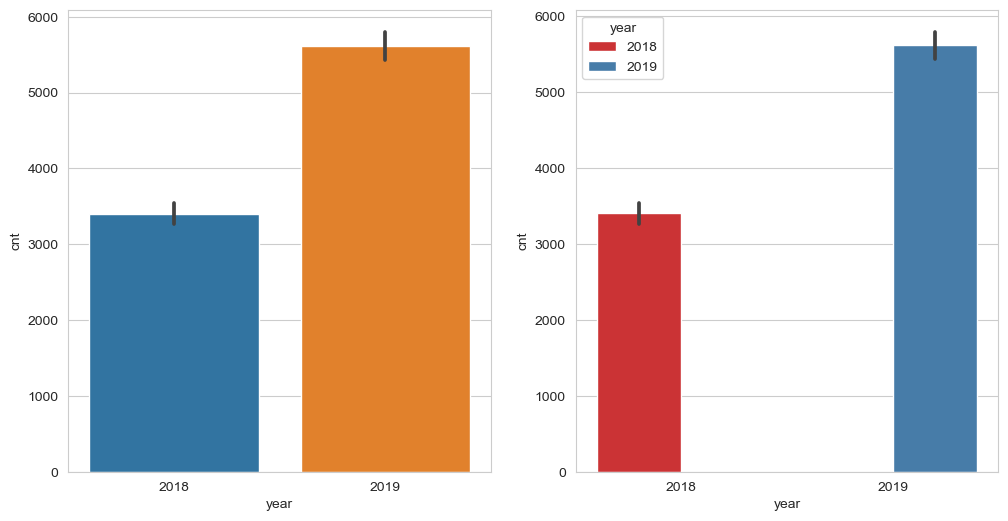

In [27]:
# plotting bar plot for year column
plot_categorical_column('year')

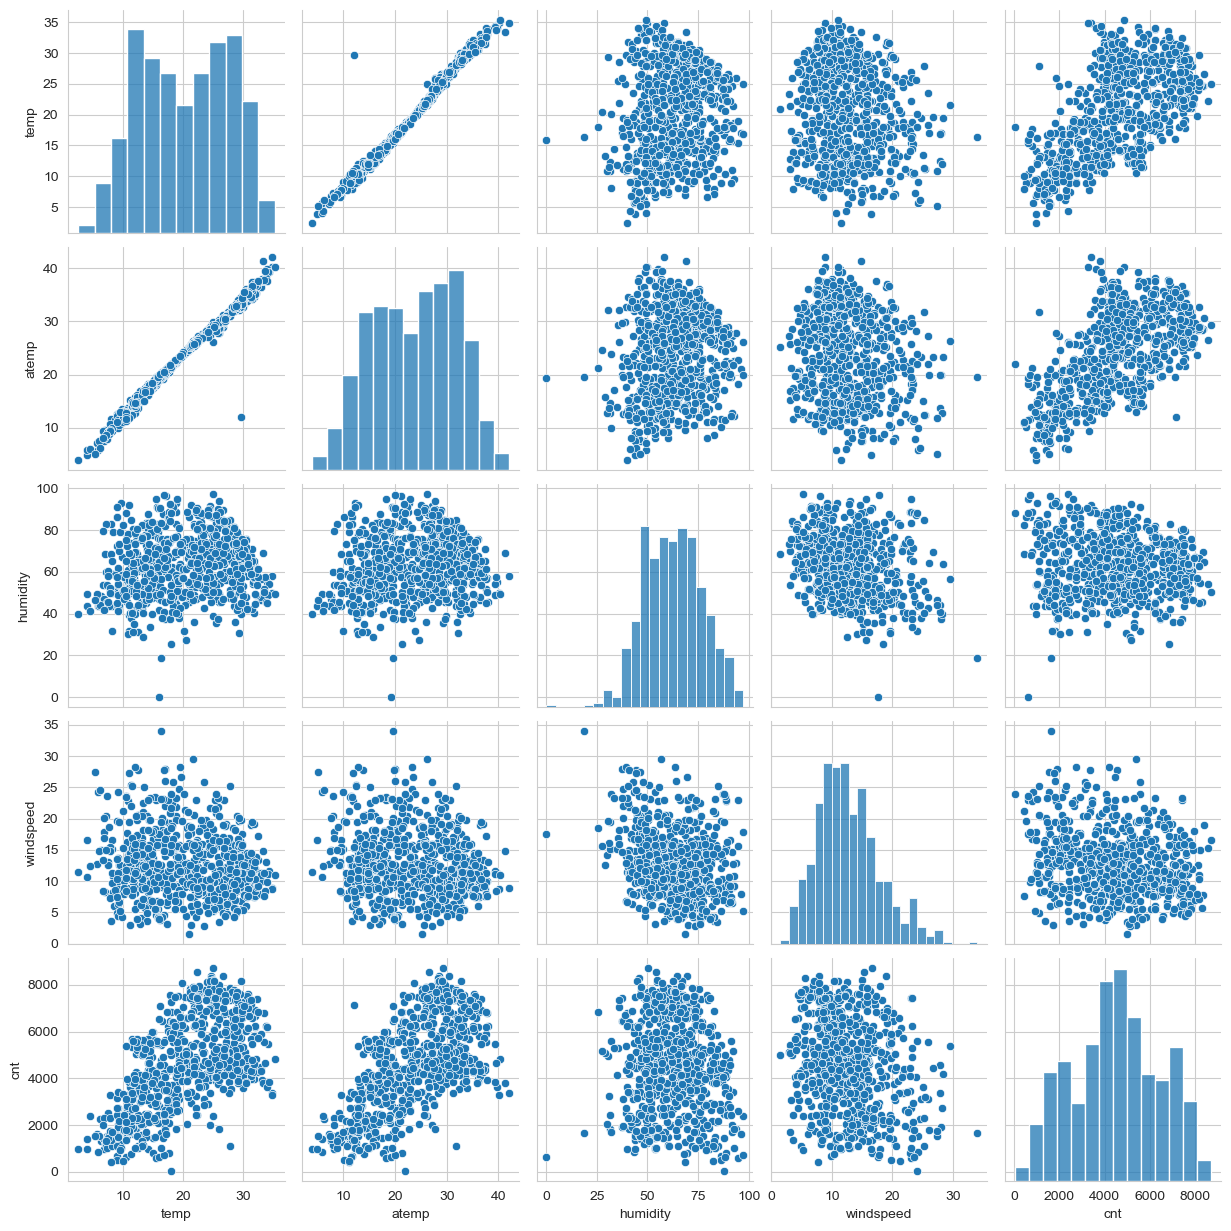

In [28]:
# Visualizing the numerical columns
sns.pairplot(data=bike_data_new,vars=['temp','atemp','humidity','windspeed','cnt'])
plt.show()

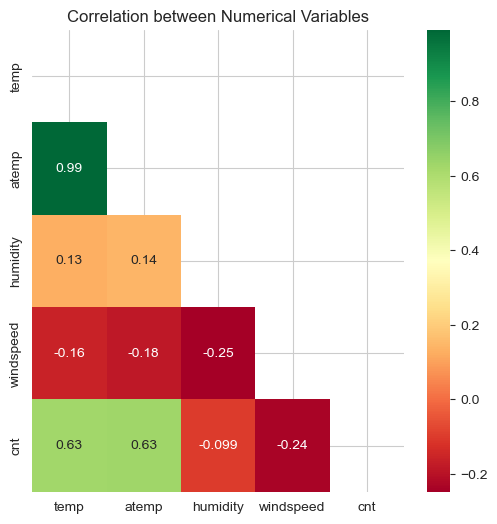

In [29]:
# Checking the correlation between the numerical variables

plt.figure(figsize = (6,6))
matrix = np.triu(bike_data_new[['temp','atemp','humidity','windspeed','cnt']].corr())
sns.heatmap(bike_data_new[['temp','atemp','humidity','windspeed','cnt']].corr(), annot = True, cmap="RdYlGn", mask=matrix)
plt.title("Correlation between Numerical Variables")
plt.show()

### Observation: There is linier coorelation between temp and atemp, we can ignore any one column. 
-Lets consider only temp for further analysis

# Preparing Data for analysis

In [30]:
# Creating dummy variables creation for month, weekday, weathersit and season variables.

months_data=pd.get_dummies(bike_data_new.month,drop_first=True)
weekdays_data=pd.get_dummies(bike_data_new.weekday,drop_first=True)
weathersit_data=pd.get_dummies(bike_data_new.weathersit,drop_first=True)
seasons_data=pd.get_dummies(bike_data_new.season,drop_first=True)

In [31]:
# Merging main dataframe bike_data_new, with the dummy variable datasets. 

bike_data_with_dummies = pd.concat([bike_data_new,months_data,weekdays_data,weathersit_data,seasons_data],axis=1)
bike_data_with_dummies

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
0,spring,2018,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
1,spring,2018,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
2,spring,2018,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,spring,2018,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,spring,2018,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,2019,dec,0,thu,1,Misty,10.420847,11.33210,65.2917,23.458911,2114,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
726,spring,2019,dec,0,fri,1,Misty,10.386653,12.75230,59.0000,10.416557,3095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
727,spring,2019,dec,0,sat,0,Misty,10.386653,12.12000,75.2917,8.333661,1341,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
728,spring,2019,dec,0,sun,0,Clear,10.489153,11.58500,48.3333,23.500518,1796,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [32]:
bike_data_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   season          730 non-null    category
 1   year            730 non-null    category
 2   month           730 non-null    category
 3   holiday         730 non-null    category
 4   weekday         730 non-null    category
 5   workingday      730 non-null    category
 6   weathersit      730 non-null    category
 7   temp            730 non-null    float64 
 8   atemp           730 non-null    float64 
 9   humidity        730 non-null    float64 
 10  windspeed       730 non-null    float64 
 11  cnt             730 non-null    int64   
 12  aug             730 non-null    uint8   
 13  dec             730 non-null    uint8   
 14  feb             730 non-null    uint8   
 15  jan             730 non-null    uint8   
 16  july            730 non-null    uint8   
 17  june            

In [33]:
# Since we have added the dummy columns for month, weekday, weathersit and season variables.
# We can drop the original column now

bike_data_with_dummies.drop(['season','month','weekday','weathersit'], axis = 1, inplace = True)
bike_data_with_dummies

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
0,2018,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
1,2018,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
2,2018,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,2018,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,2018,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2019,0,1,10.420847,11.33210,65.2917,23.458911,2114,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
726,2019,0,1,10.386653,12.75230,59.0000,10.416557,3095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
727,2019,0,0,10.386653,12.12000,75.2917,8.333661,1341,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
728,2019,0,0,10.489153,11.58500,48.3333,23.500518,1796,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


# Step 4: (Train Test Split) Splitting the Data into Training and Testing Sets

In [34]:
# splitting the dataframe into Train and Test

np.random.seed(0)
bike_data_train, bike_data_test = train_test_split(bike_data_with_dummies, train_size = 0.7, random_state = 100)
print(bike_data_train.shape)
print(bike_data_test.shape)

(510, 30)
(220, 30)


In [35]:
# Creating a MinMaxScaler instance which wil be used to rescaling the features
scaler = MinMaxScaler()

In [36]:
# dataset before scaling.
bike_data_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
576,2019,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
426,2019,0,0,16.980847,20.6746,62.1250,10.792293,4066,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
728,2019,0,0,10.489153,11.5850,48.3333,23.500518,1796,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
482,2019,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
111,2018,0,1,13.803347,16.0977,72.9583,14.707907,1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [37]:
# Apply scaler to below columns-
# 'temp','atemp','humidity','windspeed','cnt'
# Not for dummy variables
numeric_vars = ['temp','atemp','humidity','windspeed','cnt']
bike_data_train[numeric_vars] = scaler.fit_transform(bike_data_train[numeric_vars])

In [38]:
# dataset after scaling.
bike_data_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
576,2019,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
426,2019,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
728,2019,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
482,2019,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
111,2018,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


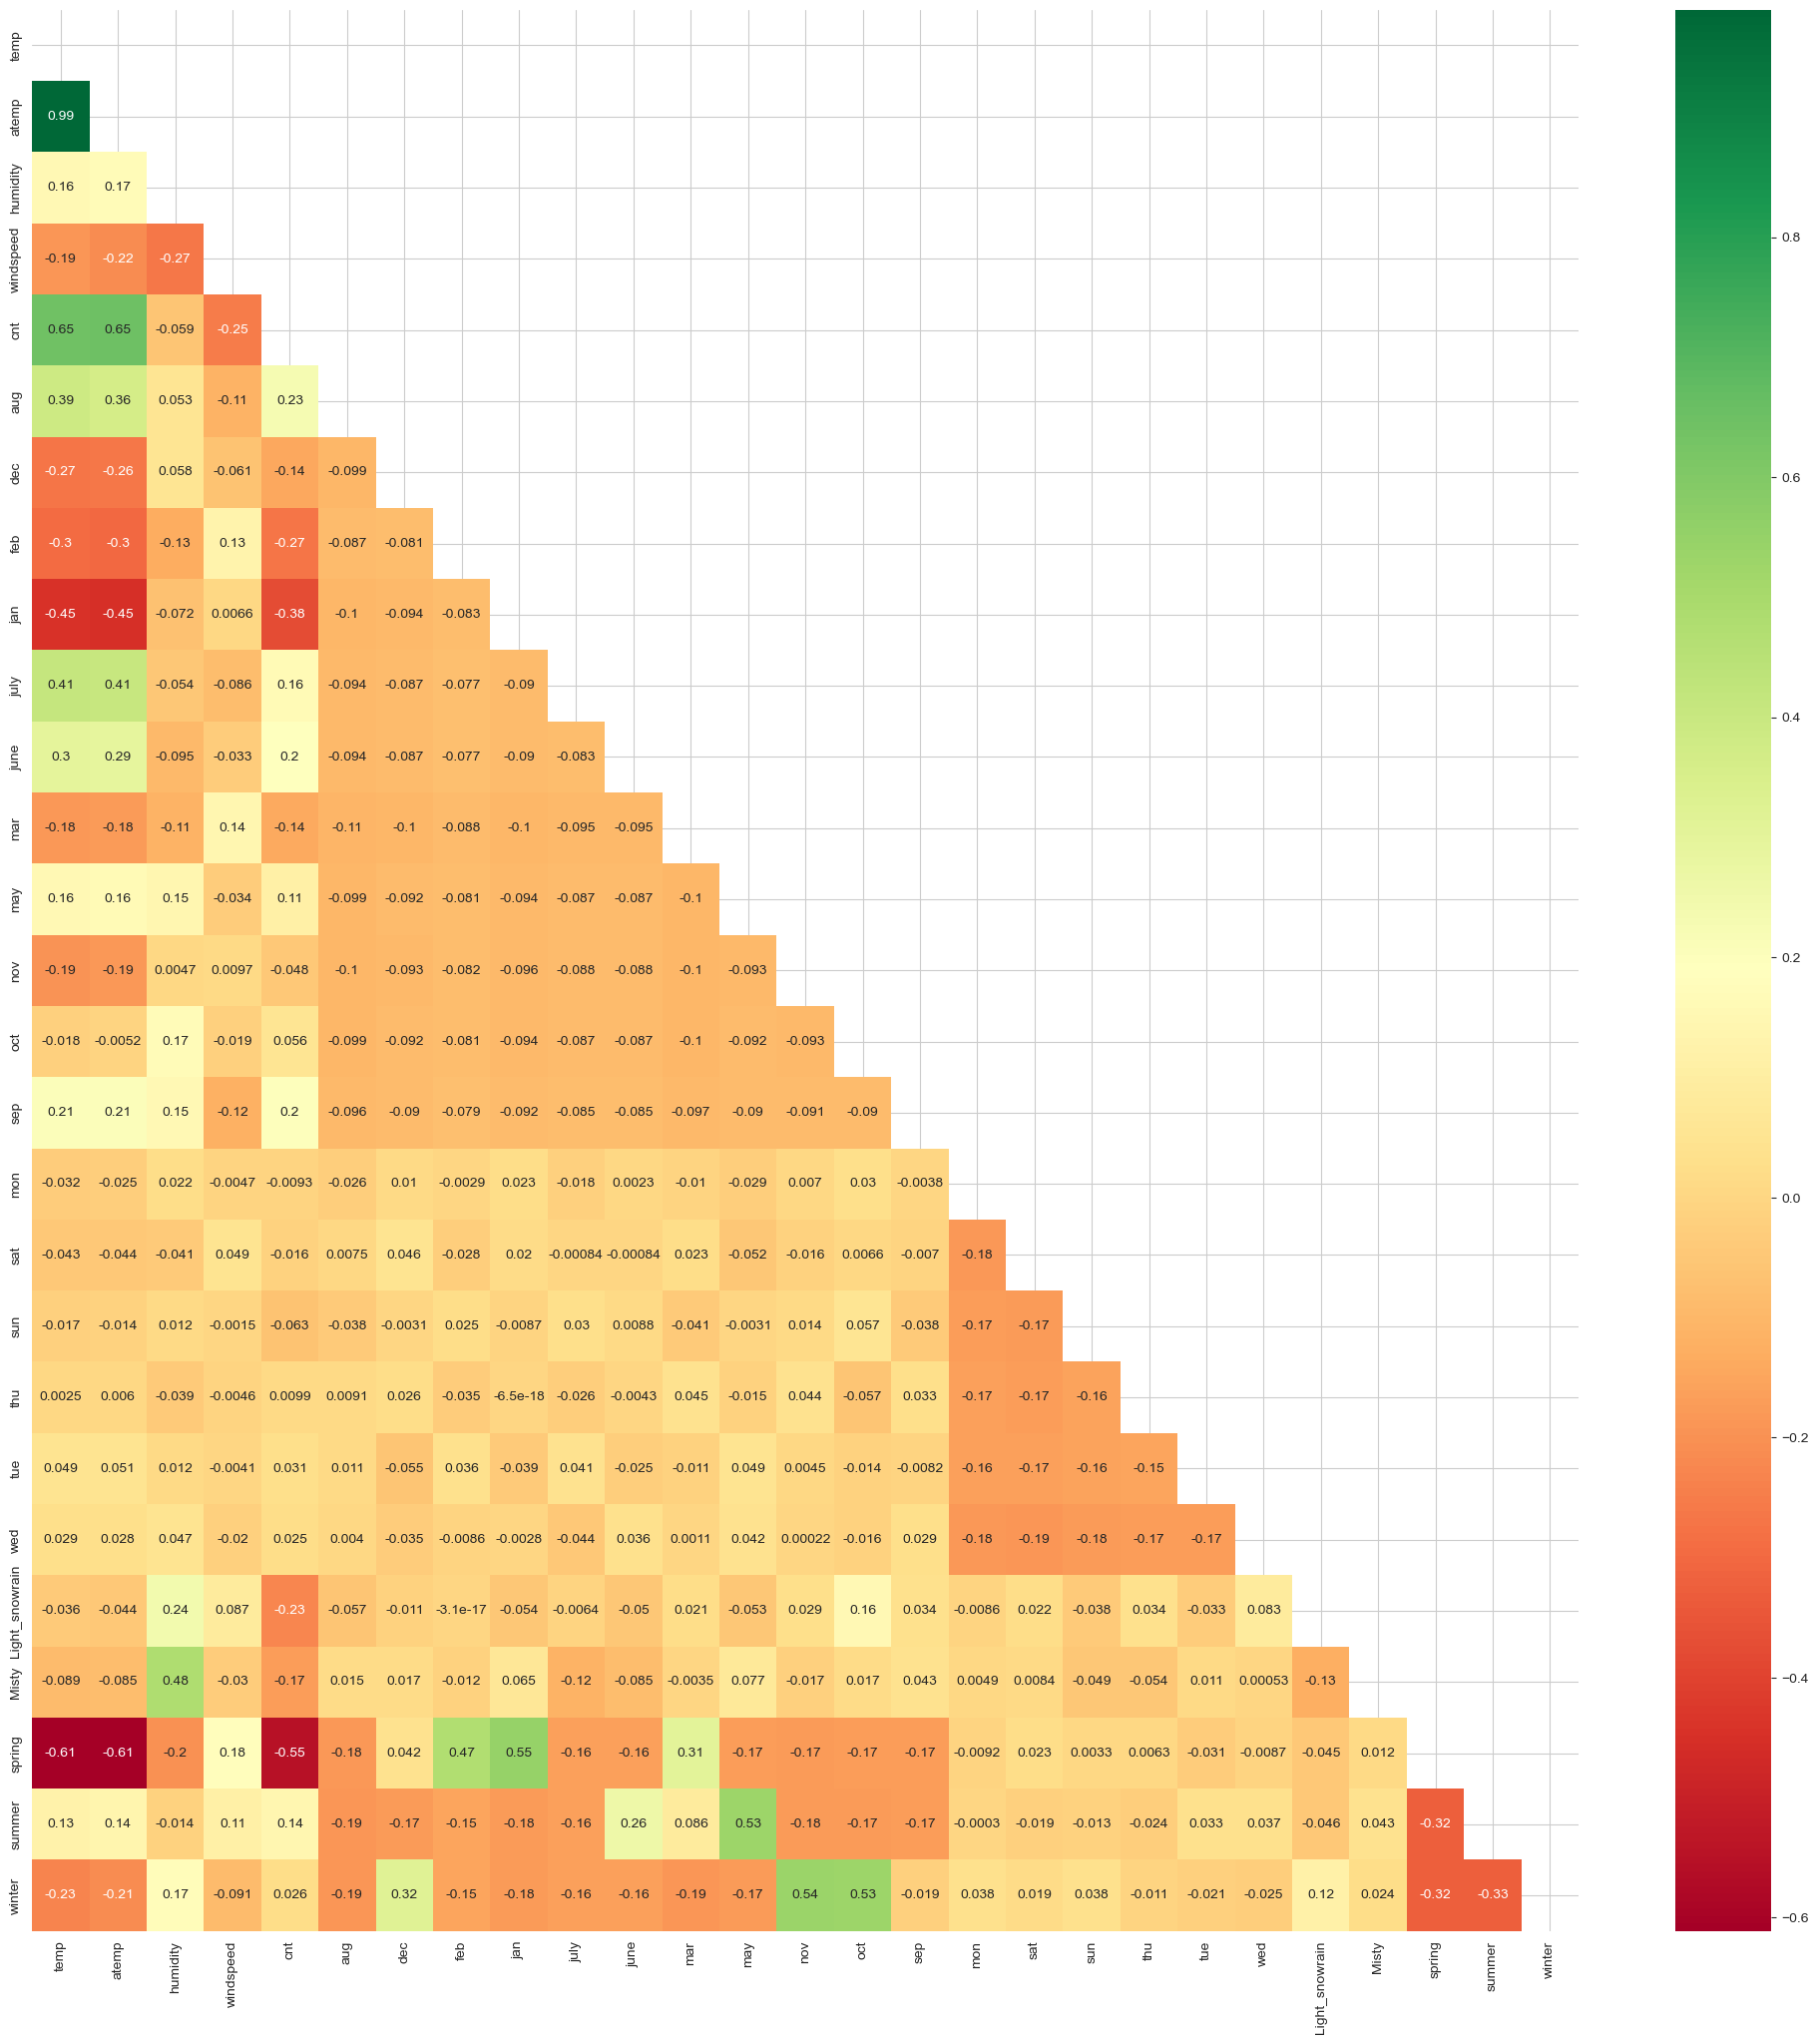

In [39]:
# checking the correlation coefficients in bike_data_train dataset 

plt.figure(figsize = (25,25))
matrix = np.triu(bike_data_train.corr())
sns.heatmap(bike_data_train.corr(), annot = True, cmap="RdYlGn", mask=matrix)
plt.show()

## Observations:
    - cnt has coorelation with temp
    - humidity has coorelation with Misty
    - winter with nov and oct..etc

In [40]:
# Building the Linear Model

y_train = bike_data_train.pop('cnt')
X_train = bike_data_train

In [41]:
# Recursive feature elimination 

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, step=15)
rfe = rfe.fit(X_train, y_train)

In [42]:
#List of variables selected in top 15 list

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 2),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('aug', False, 2),
 ('dec', True, 1),
 ('feb', False, 2),
 ('jan', True, 1),
 ('july', False, 2),
 ('june', False, 2),
 ('mar', False, 2),
 ('may', False, 2),
 ('nov', False, 2),
 ('oct', False, 2),
 ('sep', True, 1),
 ('mon', False, 2),
 ('sat', False, 2),
 ('sun', False, 2),
 ('thu', False, 2),
 ('tue', False, 2),
 ('wed', False, 2),
 ('Light_snowrain', True, 1),
 ('Misty', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1)]

In [43]:
# selecting the selected variable via RFE in col list

col = X_train.columns[rfe.support_]
print(col)

Index(['year', 'holiday', 'temp', 'atemp', 'humidity', 'windspeed', 'dec',
       'jan', 'sep', 'Light_snowrain', 'Misty', 'spring', 'summer', 'winter'],
      dtype='object')


In [44]:
# checking which columns has been rejected

X_train.columns[~rfe.support_]

Index(['workingday', 'aug', 'feb', 'july', 'june', 'mar', 'may', 'nov', 'oct',
       'mon', 'sat', 'sun', 'thu', 'tue', 'wed'],
      dtype='object')

In [45]:
# Generic function to calculate VIF of variables

def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

In [46]:
# dataframe with RFE selected variables

X_train_rfe = X_train[col]

In [47]:
# calculate VIF
vif = calculateVIF(X_train_rfe)
vif

,Features,VIF
2,temp,389.35
3,atemp,366.91
0,year,77.20
4,humidity,39.60
11,spring,6.56
5,windspeed,5.77
13,winter,4.63
12,summer,3.25
10,Misty,2.38
7,jan,1.80


# Step5: Model Building

In [48]:
# Building 1st linear regression model

X_train_lm_1 = sm.add_constant(X_train_rfe)
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     186.6
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          4.12e-187
Time:                        16:31:18   Log-Likelihood:                 507.38
No. Observations:                 510   AIC:                            -984.8
Df Residuals:                     495   BIC:                            -921.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -465.9037     16.519    -28.

In [49]:
# As humidity shows high VIF values hence we can drop it
X_train_new = X_train_rfe.drop(['humidity'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,389.15
3,atemp,366.15
0,year,58.82
10,spring,6.48
4,windspeed,5.38
12,winter,4.44
11,summer,3.20
6,jan,1.79
9,Misty,1.59
5,dec,1.37


In [50]:
# Building 2nd linear regression model

X_train_lm_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lm_2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     193.7
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          9.34e-185
Time:                        16:31:18   Log-Likelihood:                 499.02
No. Observations:                 510   AIC:                            -970.0
Df Residuals:                     496   BIC:                            -910.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -473.6158     16.664    -28.

In [51]:
# We can drop dec variable as it has high p-value
X_train_new = X_train_new.drop(['dec'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,387.05
3,atemp,366.06
0,year,55.42
9,spring,6.47
4,windspeed,5.33
11,winter,4.42
10,summer,3.15
5,jan,1.71
8,Misty,1.59
6,sep,1.28


In [52]:
# Building 3rd linear regression model

X_train_lm_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lm_3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     208.7
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          2.91e-185
Time:                        16:31:18   Log-Likelihood:                 497.45
No. Observations:                 510   AIC:                            -968.9
Df Residuals:                     497   BIC:                            -913.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -473.6472     16.698    -28.

In [53]:
# We can drop jan variable as it has high p-value
X_train_new = X_train_new.drop(['jan'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,386.62
3,atemp,365.75
0,year,51.88
8,spring,6.37
4,windspeed,5.24
10,winter,4.30
9,summer,3.11
7,Misty,1.59
5,sep,1.28
6,Light_snowrain,1.08


In [54]:
# Building 4th linear regression model

X_train_lm_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lm_4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     225.4
Date:                Tue, 01 Aug 2023   Prob (F-statistic):          2.31e-185
Time:                        16:31:18   Log-Likelihood:                 494.87
No. Observations:                 510   AIC:                            -965.7
Df Residuals:                     498   BIC:                            -914.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -472.2048     16.754    -28.

# Observation:
We can consider the 4th model as it has very low multicolinearity between the predictors and the p-values
F-statistic: 225.4 (which is >1) and p value is very low, so we can consider this model as the most appropriate

In [55]:
lr_4.params

const            -472.204767
year                0.234091
holiday            -0.096562
temp                0.508598
atemp              -0.032420
windspeed          -0.149359
sep                 0.091192
Light_snowrain     -0.285350
Misty              -0.078749
spring             -0.054771
summer              0.062753
winter              0.095281
dtype: float64

# Step 6: Train Data : Residual Analysis

In [56]:
X_train_lm_4.head()

,const,year,holiday,temp,atemp,windspeed,sep,Light_snowrain,Misty,spring,summer,winter
576,1.0,2019,0,0.815169,0.766351,0.264686,0,0,0,0,0,0
426,1.0,2019,0,0.442393,0.438975,0.255342,0,0,1,1,0,0
728,1.0,2019,0,0.245101,0.200348,0.663106,0,0,0,1,0,0
482,1.0,2019,0,0.395666,0.391735,0.188475,0,0,1,0,1,0
111,1.0,2018,0,0.345824,0.318819,0.380981,0,0,1,0,1,0


In [57]:
y_train_pred = lr_4.predict(X_train_lm_4)

Text(0.5, 0, 'Errors')

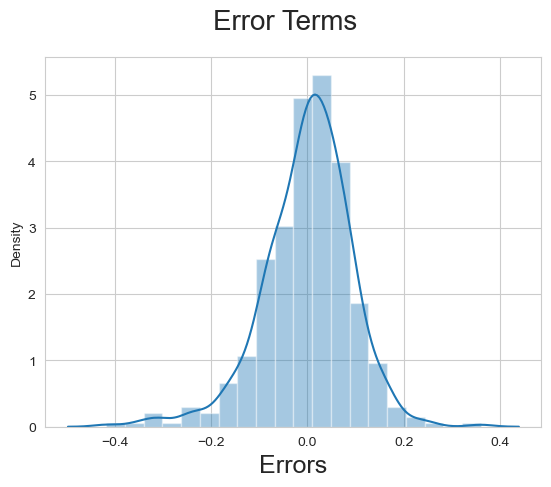

In [58]:
# Normality of error terms : Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)

In [59]:
#Multi Colinearity
calculateVIF(X_train_new)

,Features,VIF
2,temp,386.62
3,atemp,365.75
0,year,51.88
8,spring,6.37
4,windspeed,5.24
10,winter,4.30
9,summer,3.11
7,Misty,1.59
5,sep,1.28
6,Light_snowrain,1.08


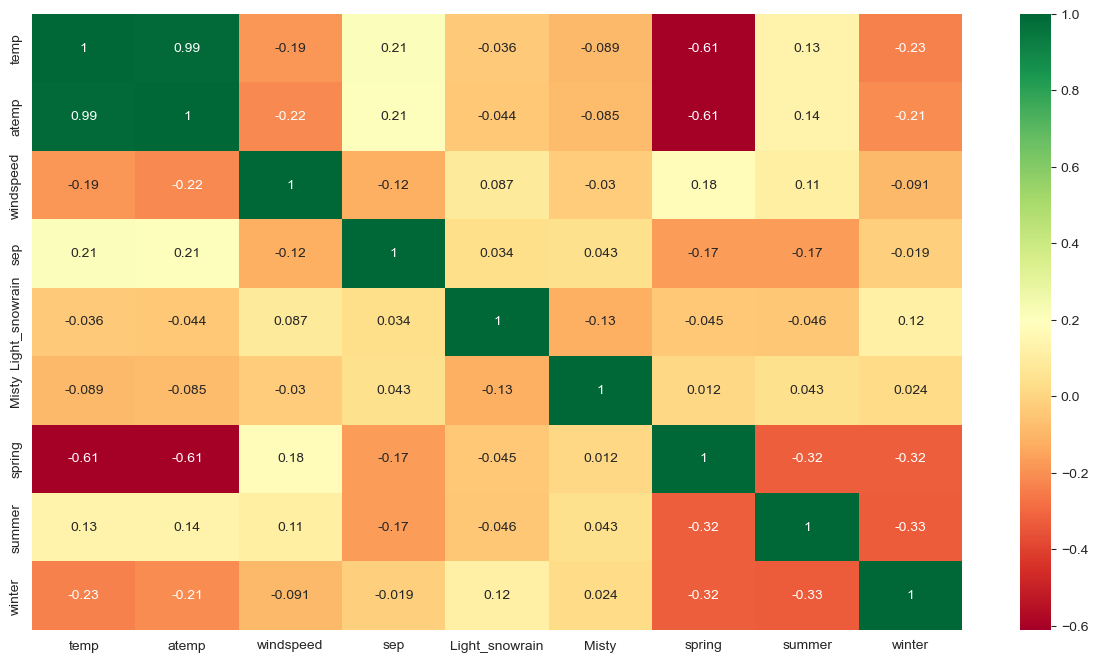

In [60]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train_new.corr(),annot = True, cmap="RdYlGn")
plt.show()

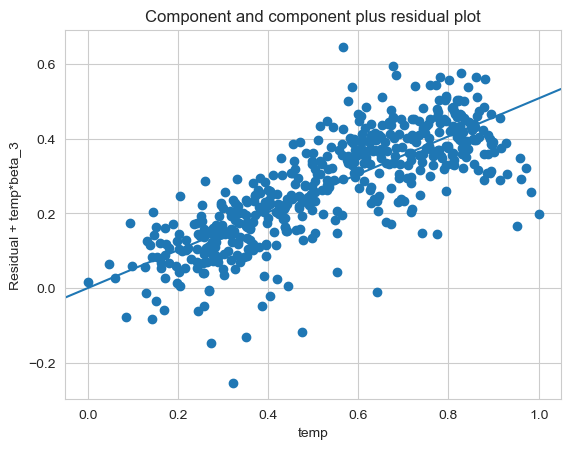

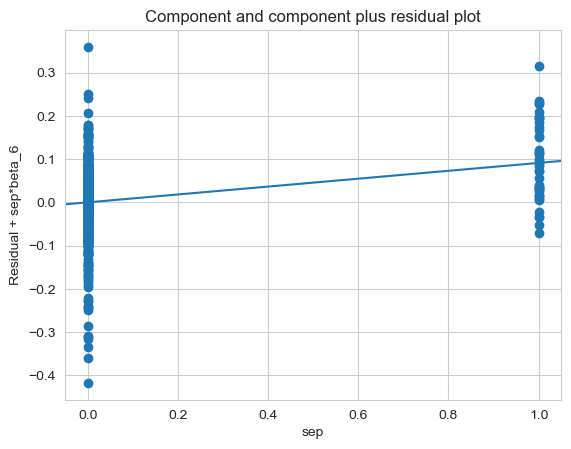

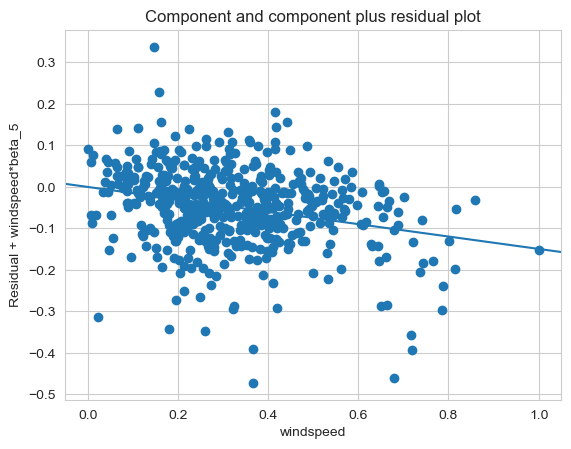

In [61]:
#Linearlity

sm.graphics.plot_ccpr(lr_4, 'temp')
plt.show()

sm.graphics.plot_ccpr(lr_4, 'sep')
plt.show()

sm.graphics.plot_ccpr(lr_4, 'windspeed')
plt.show()

# Step 7: Predictions Using the Final Model i.e 4th model

In [62]:
# Applying scaling on the test dataset

num_vars = ['temp', 'atemp', 'humidity', 'windspeed','cnt']
bike_data_test[num_vars] = scaler.transform(bike_data_test[num_vars])
bike_data_test.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
184,2018,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
535,2019,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
299,2018,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
221,2018,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
152,2018,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


# Step 8: Model Evaluation
 - Visualizing the actual predicted values.

In [63]:
y_test = bike_data_test.pop('cnt')
X_test = bike_data_test


In [64]:
col1 = X_train_new.columns

X_test = X_test[col1]

# Adding constant variable to test dataframe
X_test_lm_4 = sm.add_constant(X_test)

y_pred = lr_4.predict(X_test_lm_4)

r2 = r2_score(y_test, y_pred)
round(r2,4)

0.8035

Text(0, 0.5, 'y_pred')

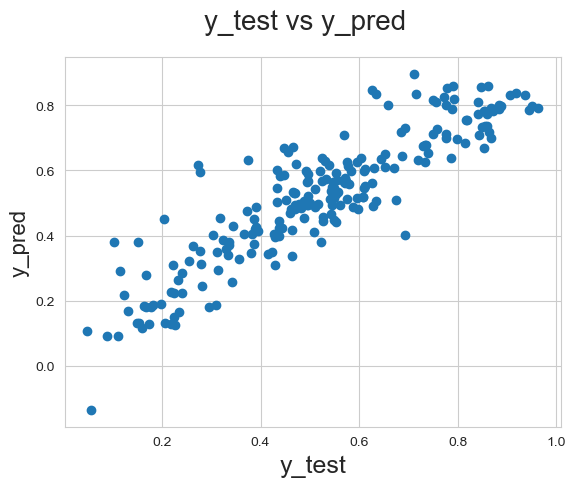

In [65]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20) 
plt.xlabel('y_test', fontsize = 18)
plt.ylabel('y_pred', fontsize = 16) 

In [67]:
round(lr_4.params,4)

const            -472.2048
year                0.2341
holiday            -0.0966
temp                0.5086
atemp              -0.0324
windspeed          -0.1494
sep                 0.0912
Light_snowrain     -0.2853
Misty              -0.0787
spring             -0.0548
summer              0.0628
winter              0.0953
dtype: float64

In [68]:
# Calculating Adjusted-R^2 value for the test dataset

adjusted_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adjusted_r2)

0.7931


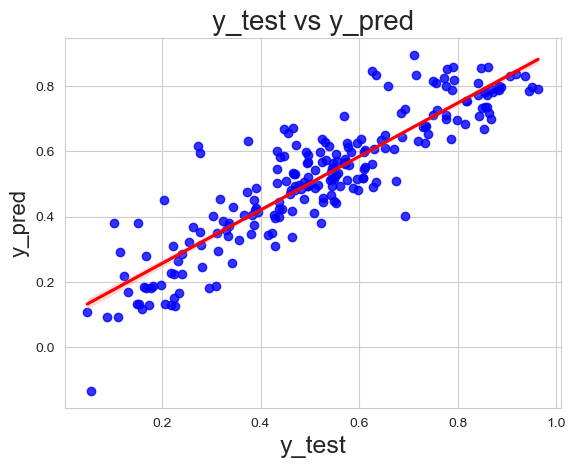

In [69]:
# Visualizing the fit on the test data
# plotting a Regression plot

plt.figure()
sns.regplot(x=y_test, y=y_pred, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()

## Observations
- Train dataset R-squared      : 0.833
- Test dataset R-squared       : 0.8035
- Train dataset Adj. R-squared : 0.829    
- Test dataset Adj. R-squared  : 0.7931

Demand of bikes depend on holiday, temp, windspeed, year, sep, Misty, spring, summer and winter.
